In [1]:
import numpy as np
import struct
import cv2
import matplotlib.pyplot as plt

def read_depth_dmb(file_path):
    """
    Reads a .dmb file containing a single-channel float depth map.
    """
    with open(file_path, 'rb') as f:
        # Read the header: type (int32), height (int32), width (int32), channels (int32)
        header = struct.unpack('<iiii', f.read(16))
        file_type, height, width, channels = header
        
        # Check if it's a single-channel float file
        if file_type != 1 or channels != 1:
            raise ValueError(f"File {file_path} is not a single-channel float DMB file.")
            
        # Read the image data
        num_elements = width * height
        data = np.fromfile(f, dtype=np.float32, count=num_elements)
        
        # Reshape the data into a 2D numpy array
        depth_map = data.reshape((height, width))
        
        return depth_map

def read_normal_dmb(file_path):
    """
    Reads a .dmb file containing a 3-channel float normal map.
    """
    with open(file_path, 'rb') as f:
        # Read the header
        header = struct.unpack('<iiii', f.read(16))
        file_type, height, width, channels = header
        
        if file_type != 1 or channels != 3:
            raise ValueError(f"File {file_path} is not a 3-channel float DMB file.")
        
        # Read the image data
        num_elements = width * height * 3
        data = np.fromfile(f, dtype=np.float32, count=num_elements)
        
        # Reshape the data into a 3D numpy array (H, W, C)
        normal_map = data.reshape((height, width, 3))
        
        return normal_map

In [2]:
# !pip install numpy opencv-python matplotlib

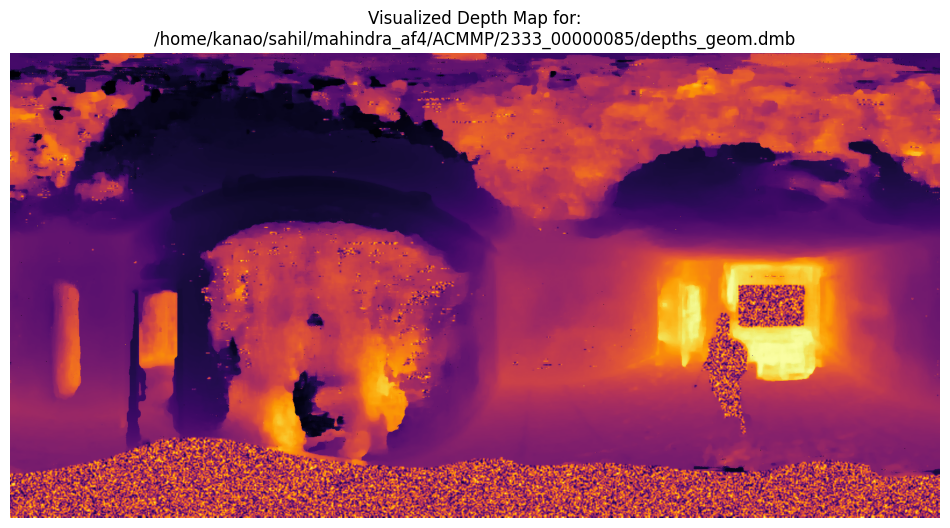

In [3]:
# --- 1. SET THE PATH TO YOUR DEPTH MAP ---
# Make sure this path is correct for your system
file_path = '/home/kanao/sahil/mahindra_af4/ACMMP/2333_00000085/depths_geom.dmb' 

try:
    # --- 2. LOAD THE DEPTH MAP ---
    depth_map = read_depth_dmb(file_path)
    
    # --- 3. VISUALIZE THE DEPTH MAP ---
    
    # Create a mask for valid depth values (ignore non-positive depths)
    valid_mask = depth_map > 0
    
    # Create a copy to work with, setting invalid depths to 0 for normalization
    display_map = depth_map.copy()
    display_map[~valid_mask] = 0
    
    # Normalize the valid depth values to the 0-255 range for visualization
    normalized_map = cv2.normalize(display_map, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    # Apply a color map for better visual interpretation
    # INFERNO, MAGMA, and VIRIDIS are often better than JET for perception
    colored_map = cv2.applyColorMap(normalized_map, cv2.COLORMAP_INFERNO)
    
    # Set the invalid regions to black
    colored_map[~valid_mask] = [0, 0, 0]
    
    # --- 4. DISPLAY THE IMAGE ---
    # Convert from OpenCV's BGR format to Matplotlib's RGB format
    colored_map_rgb = cv2.cvtColor(colored_map, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(colored_map_rgb)
    plt.title(f'Visualized Depth Map for:\n{file_path}')
    plt.axis('off') # Hide the axes
    plt.show()

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except ValueError as e:
    print(f"Error reading file: {e}")

In [4]:
import numpy as np
import cv2
import open3d as o3d
import struct
import math

# You can reuse this function from the previous answer
def read_depth_dmb(file_path):
    with open(file_path, 'rb') as f:
        header = struct.unpack('<iiii', f.read(16))
        file_type, height, width, channels = header
        if file_type != 1 or channels != 1:
            raise ValueError(f"File {file_path} is not a single-channel float DMB file.")
        data = np.fromfile(f, dtype=np.float32, count=width*height)
        return data.reshape((height, width))

def read_camera_txt(file_path):
    """
    Reads a _cam.txt file and returns a dictionary with camera parameters.
    This is a corrected, more robust version.
    """
    camera = {}
    with open(file_path, 'r') as f:
        # Read all lines and remove leading/trailing whitespace
        lines = [line.strip() for line in f.readlines()]

    try:
        # --- Parse Extrinsics ---
        # Find the line index of the 'extrinsic' keyword
        ext_idx = lines.index('extrinsic')
        # The next 3 lines are the R and t matrix
        ext_data = [list(map(float, lines[i].split())) for i in range(ext_idx + 1, ext_idx + 4)]
        extrinsics = np.array(ext_data)
        camera['R'] = extrinsics[:, :3]
        camera['t'] = extrinsics[:, 3]
    except (ValueError, IndexError):
        raise ValueError(f"Could not parse extrinsics from camera file: {file_path}")

    try:
        # --- Parse Intrinsics ---
        # Find the line index of the 'intrinsic' keyword
        int_idx = lines.index('intrinsic')
        # The model name is on the next line
        model = lines[int_idx + 1]

        if model == 'SPHERE':
            camera['model'] = 'sphere'
            # The parameters (f, w, h) are on the line after the model name
            params = list(map(float, lines[int_idx + 2].split()))
            
            # The depth range is the last non-empty line in the file
            depth_range_line = [line for line in lines if line][-1]
            depth_range = list(map(float, depth_range_line.split()))

            # NOTE: Your file shows width=960, height=480. These values are used here.
            camera['width'] = int(params[1]*2)
            camera['height'] = int(params[2]*2)
            camera['depth_min'] = depth_range[0]
            camera['depth_max'] = depth_range[1]

        else:
            camera['model'] = 'pinhole'
            # (Add logic for parsing pinhole cameras here if needed in the future)
            raise NotImplementedError("Pinhole parsing not fully implemented in this example.")
            
    except (ValueError, IndexError):
        raise ValueError(f"Could not parse intrinsics from camera file: {file_path}")
        
    return camera


def get_3d_point_on_world(u, v, depth, camera):
    """
    Performs back-projection for a single pixel (u,v) with a given depth.
    Handles both SPHERICAL and PINHOLE camera models.
    """
    # print (camera['model'])
    # print (camera['width'])
    if camera['model'] == 'sphere':
        # Spherical / equirectangular model
        lon = (u / camera['width'] - 0.5) * (2 * math.pi)
        lat = -(v / camera['height'] - 0.5) * math.pi
        
        # 3D point in camera coordinates
        cam_x = depth * math.cos(lat) * math.sin(lon)
        cam_y = depth * -math.sin(lat)
        cam_z = depth * math.cos(lat) * math.cos(lon)
        point_cam = np.array([cam_x, cam_y, cam_z])
    
    else: # Pinhole model
        # Assuming K matrix is available in camera['K']
        # This part is not implemented as your data is spherical
        raise NotImplementedError("Pinhole model back-projection not implemented.")

    # Transform from camera coordinates to world coordinates
    R_inv = camera['R'].T
    t_inv = -R_inv @ camera['t']
    
    point_world = R_inv @ point_cam + t_inv
    return point_world

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [11]:
# --- 1. DEFINE WHICH IMAGE TO PROCESS ---
image_id = "00000289"
base_path = "/home/kanao/sahil/mahindra_af4" # The path you provided to the C++ program

# Construct the full paths
image_path = f"{base_path}/images/{image_id}.jpg"
depth_path = f"{base_path}/ACMMP/2333_{image_id}/depths.dmb"
camera_path = f"{base_path}/cams/{image_id}_cam.txt"

# --- 2. LOAD ALL NECESSARY DATA ---
try:
    color_image = cv2.imread(image_path)
    # Convert from BGR (OpenCV default) to RGB for correct coloring
    color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
    
    depth_map = read_depth_dmb(depth_path)
    camera = read_camera_txt(camera_path)
    
    # Verify that image and depth map dimensions match
    print(color_image.shape[:2] , depth_map.shape) 
    assert color_image.shape[:2] == depth_map.shape, "Image and Depth map dimensions do not match!"

except (FileNotFoundError, AssertionError) as e:
    print(f"Error loading data: {e}")
else:
    # --- 3. GENERATE POINT CLOUD ---
    print("Generating point cloud... (This may take a moment)")
    
    points = []
    colors = []
    
    # Get indices of all pixels with valid depth
    # NOTE: We only use positive depth for easier visualization,
    # though your data range can be negative.
    valid_pixels = np.where(depth_map > 0)
    
    for y, x in zip(*valid_pixels):
        depth = depth_map[y, x]
        
        # Get the 3D point in world coordinates
        point_3d = get_3d_point_on_world(x, y, depth, camera)
        points.append(point_3d)
        
        # Get the color for that point
        colors.append(color_image[y, x] / 255.0) # Normalize color to [0, 1] for Open3D

    # --- 4. CREATE AND VISUALIZE OPEN3D POINT CLOUD ---
    if points:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(np.array(points))
        pcd.colors = o3d.utility.Vector3dVector(np.array(colors))

        # Save the point cloud to a .ply file
        output_ply_path = f"point_cloud_{image_id}.ply"
        o3d.io.write_point_cloud(output_ply_path, pcd)
        print(f"Point cloud saved to {output_ply_path}")

        # Visualize the point cloud in an interactive window
        print("Displaying point cloud...")
        o3d.visualization.draw_geometries([pcd])
    else:
        print("No valid points found to create a point cloud.")

(800, 1600) (800, 1600)
Generating point cloud... (This may take a moment)
Point cloud saved to point_cloud_00000289.ply
Displaying point cloud...


In [ ]:
import numpy as np
import open3d as o3d

def voxel_density_filter(pcd, cell, min_points):
    """
    Fast O(N) filter: keep only voxels with >= min_points.
    Great to kill isolated specks before any neighbor search.
    """
    pts = np.asarray(pcd.points)
    if pts.shape[0] == 0:
        return pcd
    mins = pts.min(axis=0)
    keys = np.floor((pts - mins) / cell).astype(np.int64)

    # Unique voxel keys and counts
    uniq, inv, counts = np.unique(keys, axis=0, return_inverse=True, return_counts=True)
    keep_mask = counts[inv] >= min_points
    idx = np.nonzero(keep_mask)[0]
    return pcd.select_by_index(idx)

# ---- Load
# pcd = o3d.io.read_point_cloud("/data/some_big_cloud.ply")

# ---- Pass 1: coarser voxel (5–10 mm) to drop data volume quickly
voxel_size = 0.001  # 5 mm
pcd_vx = pcd.voxel_down_sample(voxel_size=voxel_size)

# ---- Pass 2: cheap density pre-cull (use 2–3× the voxel as the density cell)
pcd_dense = voxel_density_filter(pcd_vx, cell=0.015, min_points=5)

# ---- Pass 3: radius outlier removal (much cheaper than k=2000)
pcd_clean, _ = pcd_dense.remove_radius_outlier(nb_points=16, radius=3 * voxel_size)

# ---- Save (binary PLY)
o3d.io.write_point_cloud(
    "/data/sahil/ACMM_model_optimized_voxel_purvankara_5mm_clean.ply",
    pcd_clean,
    write_ascii=False,
    print_progress=True
)


In [ ]:
import open3d as o3d

pcd = o3d.io.read_point_cloud("/home/kanao/sahil/mahindra_af4/ACMMP/ACMM_model_cpp11_compatible.ply")

# Step 1: Uniform downsampling (select every k-th point)
every_k_points = 10  # Keep every 10th point (adjust as needed)
pcd_down = pcd.uniform_down_sample(every_k_points=every_k_points)

# Step 2: Remove statistical outliers
pcd_clean, ind = pcd_down.remove_statistical_outlier(
    nb_neighbors=2000,  # Number of neighbors to analyze
    std_ratio=2.0       # Threshold for outlier removal
)

# Optional: Save results
o3d.io.write_point_cloud("uniform_down.ply", pcd_down)

print(f"Original points: {len(pcd.points)}")
print(f"After uniform downsampling: {len(pcd_down.points)}")
# print(f"After outlier removal: {len(pcd_clean.points)}")

Original points: 445816644
After uniform downsampling: 44581665


In [3]:
!pwd

/home/kanao/sahil/ACMMP-Spherical


In [ ]:
!wormhole send /data/sahil/ACMM_model_optimized_voxel_purvankara_3200.ply

In [ ]:
q